In [28]:


#imports
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import os
import json
from pandas import json_normalize

def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [29]:
train = load_df(nrows=100000, csv_path="data/train.csv")
test = load_df("data/test.csv", 100000)

Loaded train.csv. Shape: (100000, 55)
Loaded test.csv. Shape: (100000, 53)


In [30]:
test.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
test.describe()

,date,visitId,visitNumber,visitStartTime
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05
mean,2.017577e+07,1.513966e+09,2.410840,1.513966e+09
std,4.617857e+03,6.302320e+06,9.729287,6.302320e+06
min,2.017082e+07,1.503125e+09,1.000000,1.503126e+09
25%,2.017102e+07,1.508184e+09,1.000000,1.508184e+09
50%,2.018010e+07,1.515013e+09,1.000000,1.515013e+09
75%,2.018023e+07,1.519838e+09,1.000000,1.519838e+09
max,2.018043e+07,1.525072e+09,456.000000,1.525072e+09


In [33]:
train.describe()

,date,visitId,visitNumber,visitStartTime
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05
mean,2.016536e+07,1.484710e+09,2.274210,1.484710e+09
std,4.694358e+03,9.166865e+06,9.260941,9.166865e+06
min,2.016081e+07,1.470896e+09,1.000000,1.470899e+09
25%,2.016111e+07,1.478832e+09,1.000000,1.478832e+09
50%,2.016121e+07,1.481667e+09,1.000000,1.481667e+09
75%,2.017050e+07,1.493684e+09,1.000000,1.493684e+09
max,2.017080e+07,1.501657e+09,389.000000,1.501657e+09


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    100000 non-null  object
 1   date                                               100000 non-null  int64 
 2   fullVisitorId                                      100000 non-null  object
 3   sessionId                                          100000 non-null  object
 4   socialEngagementType                               100000 non-null  object
 5   visitId                                            100000 non-null  int64 
 6   visitNumber                                        100000 non-null  int64 
 7   visitStartTime                                     100000 non-null  int64 
 8   device.browser                                     100000 non-null  object
 9   devic

We can tell that there appears to be no missing values

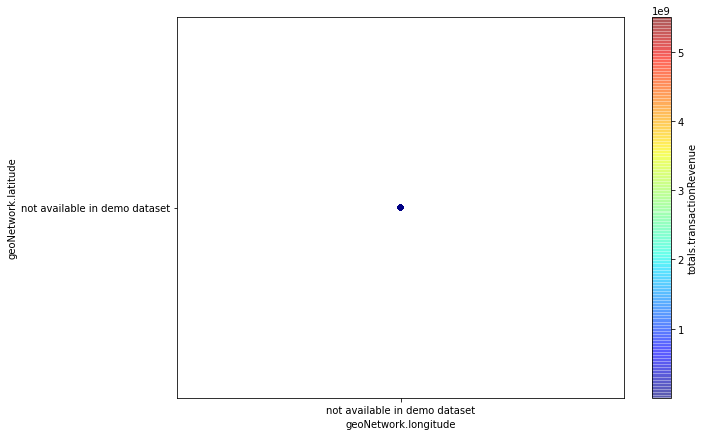

In [37]:
train.plot(kind="scatter", x="geoNetwork.longitude", y="geoNetwork.latitude", alpha=0.4,
    #s=training["totals.transactionRevenut"]/100, label="transactionRevenue", 
    figsize=(10,7),
    c="totals.transactionRevenue", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)



In [39]:
train["geoNetwork.longitude"]

0        not available in demo dataset
1        not available in demo dataset
2        not available in demo dataset
3        not available in demo dataset
4        not available in demo dataset
                     ...              
99995    not available in demo dataset
99996    not available in demo dataset
99997    not available in demo dataset
99998    not available in demo dataset
99999    not available in demo dataset
Name: geoNetwork.longitude, Length: 100000, dtype: object

In [46]:
#df = df.loc[:, (df.isnull().sum(axis=0) <= max_number_of_nas)]
#train = train.loc[:, (train.eq("not available in demo dataset"))]

# Find the columns where values are not available
useless_cols = [col for col in train.columns if train[col].eq("not available in demo dataset").all()]
# Drop these columns from the dataframe
train.drop(useless_cols,
        axis=1,
        inplace=True)
train.info()

C:\Users\steff\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               100000 non-null  object
 1   date                                          100000 non-null  int64 
 2   fullVisitorId                                 100000 non-null  object
 3   sessionId                                     100000 non-null  object
 4   socialEngagementType                          100000 non-null  object
 5   visitId                                       100000 non-null  int64 
 6   visitNumber                                   100000 non-null  int64 
 7   visitStartTime                                100000 non-null  int64 
 8   device.browser                                100000 non-null  object
 9   device.operatingSystem                        100000 non-nul

In [47]:
train["totals.transactionRevenue"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
99995    NaN
99996    NaN
99997    NaN
99998    NaN
99999    NaN
Name: totals.transactionRevenue, Length: 100000, dtype: object

Maybe add columns for lat/long using another dataset like https://simplemaps.com/data/world-cities